In [1]:
# import os
# cpu_count = os.cpu_count()
# os.environ["XLA_FLAGS"] = f'--xla_force_host_platform_device_count={cpu_count}'
# os.environ["XLA_FLAGS"] = f'--xla_force_host_platform_device_count={1}'

In [2]:
import logging
import os

from matplotlib import pyplot as plt
import numpy as np

from src.hnmf_optimizer import HNMFOptimizer, ParallelHNMFOptimizer
from src.clusts import result_analysis
from green_model import reconstruct_general, gen_init_params,  gen_bounds, clustering_preprocess


# set true variables

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#       set true variables for generated observations       #
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

### parameters ###

# The amplitudes of the original sources

# 2 sources 
As = np.array([0.5, 0.7])
# # positions of the source
Xs = np.array([
    [-0.1, -0.2],
    [-0.9, -0.8]
])



# Advection velocity
u_scaler = 0.05
# U = tf_c(np.array([0.05, 0]))
# Dispersivity
D = np.array([0.005, 0.00125])


### fixed known values ###

# the initial time the sources begin the release
Ts = -10.

# positions of the detectors
Xd = np.array([
    [0, 0],
    [-0.5, -0.5],
    [0.5, 0.5],
    [0.5, -0.5]
])


# time values of data
t = np.linspace(0, 20, 80)

# noise to add to 
noise_level = 1e-4


# NMF run

In [4]:
# generate observations from target variables with small noise

noise_level = 1e-4
observations = reconstruct_general(As, Xs, Ts, Xd, t, np.array([u_scaler]), D)
noise = noise_level/2 - noise_level*np.random.rand(*observations.shape)
observations += noise


I0000 00:00:1697858114.424289    6145 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
green_opt = ParallelHNMFOptimizer(
# green_opt = HNMFOptimizer(
    model_fn = reconstruct_general,
    param_generator = gen_init_params,
    bound_generator = gen_bounds,
    input_args = ('t',),
    param_args = ('A_s', 'X_s', 'U', 'D'),
    constants = {'T_s': Ts, 'X_d': Xd},
    min_k = 1,
    max_k = 4,
    nsim = 100
)

res = green_opt(t, observations)
Forclusts = clustering_preprocess(res)

Forclusts = Forclusts.groupby('num_sources', group_keys=False).apply(lambda group: result_analysis(
    group['points'].sum(),
    group['normF'].mean(),
    observations.size,
    group['num_sources'].iloc[0]
))

SIMULATIONS FOR 1 SOURCES TOOK 176.67956399917603 SECONDS
SIMULATIONS FOR 2 SOURCES TOOK 207.3183469772339 SECONDS
SIMULATIONS FOR 3 SOURCES TOOK 211.12869930267334 SECONDS
SIMULATIONS FOR 4 SOURCES TOOK 227.81741380691528 SECONDS
Clustering  2
Clustering  3
Clustering  4


In [6]:
res[res['num_sources'] == 2]['sol'].to_list()


[[Array([0.95775457, 0.54663364], dtype=float64),
  Array([[-0.31222604,  0.70255795],
         [ 0.24321204, -0.62196657]], dtype=float64),
  Array([0.08102506], dtype=float64),
  Array([9.77543578e-01, 3.84414458e-04], dtype=float64)],
 [Array([0.03905113, 0.50784769], dtype=float64),
  Array([[ 0.9219454 ,  0.91581803],
         [-0.35184265, -0.49382413]], dtype=float64),
  Array([0.02813366], dtype=float64),
  Array([0.00427232, 0.00206394], dtype=float64)],
 [Array([0.79846818, 0.87258503], dtype=float64),
  Array([[ 0.52792524, -0.62071229],
         [ 0.78546127, -0.95156076]], dtype=float64),
  Array([-0.02830838], dtype=float64),
  Array([8.26232168e-01, 4.38448944e-04], dtype=float64)],
 [Array([0.46544547, 0.26603786], dtype=float64),
  Array([[ 0.44614882, -0.13361847],
         [ 0.00085898, -0.37624205]], dtype=float64),
  Array([0.00627683], dtype=float64),
  Array([0.08051546, 0.00179958], dtype=float64)],
 [Array([0.73800593, 1.43651875], dtype=float64),
  Array([[-0.

In [7]:
Forclusts

,num_source,aic_score,avg_sillhouette_score,min_sillhouette_score,reconstruction_loss,centers
0,1,-825.731774,1.000000,1.000000,24.086685,"[2.5368514651444922, 0.39873678967733006, -0.4..."
0,2,inf,0.237981,-0.241976,10.020325,"[[254.93736184232216, -45.410859348168245], [1..."
0,3,inf,0.160206,-0.029685,7.441774,"[[3.965816343065124, -13.184918180137124, 54.4..."
0,4,inf,0.117451,-0.249483,2.365052,"[[4.930151514060481, -4.01104387708047, -16.17..."


In [8]:
def plot_results_stability_plot(numsources,avgsilsall,minsillsall,recs_all, output_dir):
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel('Number of Sources')
    ax1.set_ylabel('Reconstruction Error [%]', color=color)  # we already handled the x-label with ax1
    ax1.plot(numsources, recs_all, color=color,marker = 'o')
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Silhouette Score', color=color)
    ax2.plot(numsources, avgsilsall, color=color,label='Avg_sil',marker = 'o')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.plot(numsources, minsillsall, color='pink', label='Min_sill', marker='o')
    ax2.legend(loc='upper right')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig(output_dir+"Selection_plot.png")
    plt.show()

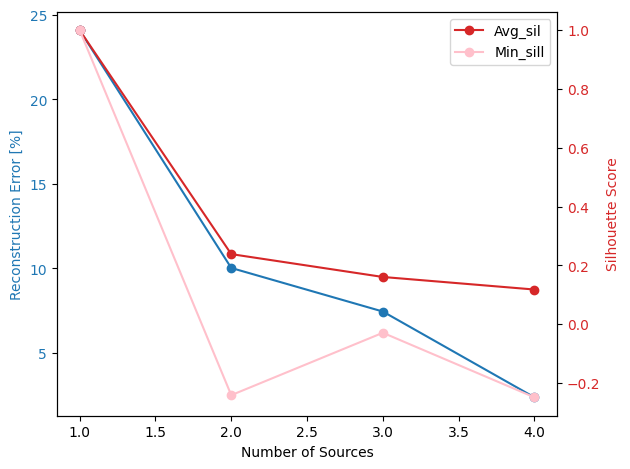

In [9]:
OUTPUTDIR = "Results/"
os.makedirs(OUTPUTDIR,exist_ok=True)

numsources = Forclusts['num_source'].values
avgsilsall    = Forclusts['avg_sillhouette_score'].values
minsillsall   = Forclusts['min_sillhouette_score'].values
recs_all   = Forclusts['reconstruction_loss'].values
plot_results_stability_plot(numsources,avgsilsall,minsillsall,recs_all,OUTPUTDIR)

In [10]:
Forclusts['centers'].iloc[1]

array([[ 2.54937362e+02, -4.54108593e+01],
       [ 1.60559897e+00, -2.56253315e+00],
       [-1.25047980e-01, -4.00831818e-01],
       [ 4.32671189e-02,  4.32671189e-02],
       [ 7.97386272e-01,  7.97386272e-01],
       [-4.29387013e-02, -4.29387013e-02]])

In [11]:
ground_truth=np.vstack([As,Xs.T])
ground_truth

array([[ 0.5,  0.7],
       [-0.1, -0.9],
       [-0.2, -0.8]])